In [1]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio

from rasterio.plot import show
from rasterio.features import shapes
from shapely.geometry import shape


In [5]:
data_dir = '/Users/d3y010/projects/atiim/data'

gage_data_csv = os.path.join(data_dir, 'tabular', 'water_level.csv')
dem_file = os.path.join(data_dir, 'raster', 'run_1_all.sdat')
    
output_dir = '/Users/d3y010/projects/atiim/test'


In [9]:
def generate_water_polygons(raster_file, output_directory, elevation_interval=0.1):

    with rasterio.Env():

        with rasterio.open(raster_file) as src:

            arr = src.read(1)

            # convert the raster nodata value to numpy nan
            arr[arr == src.nodata] = np.nan

            raster_min = np.nanmin(arr)
            raster_max = np.nanmax(arr)

            elev_slices = {'lower': [], 'upper': []}
            for i in np.arange(raster_min, raster_max, elevation_interval):
                elev_slices['lower'].append(i)

                if (i + elevation_interval) < raster_max:
                    elev_slices['upper'].append(i + elevation_interval)
                else:
                    elev_slices['upper'].append(raster_max)

            for i in range(len(elev_slices['upper'])):

                low_elev = elev_slices['lower'][i]
                upper_elev = elev_slices['upper'][i]

                arx = np.where(arr <= upper_elev, 1, 0).astype(np.int16)

                results = (
                    {'properties': {'raster_val': val}, 'geometry': shp}
                    for index, (shp, val)  in enumerate(
                        shapes(arx, mask=None, transform=src.transform))
                )

                # generate list of geometries
                geoms = list(results)

                # build geopandas dataframe from geometries
                gdf = gpd.GeoDataFrame.from_features(geoms)

                # only keep the ones
                gdf = gdf.loc[gdf['raster_val'] == 1]

                # dissolve into a single polygon
                gdf = gdf.dissolve('raster_val')

                # write to file
                out_file = os.path.join(output_directory, f'wl_{int(upper_elev*10)}.shp')
                gdf.to_file(out_file, crs=src.crs)


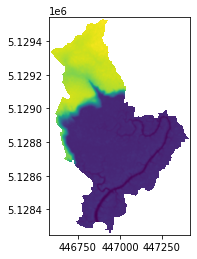

In [7]:
with rasterio.open(dem_file) as src:
    show(src)

#### This code replaces all of atiim_gage_data_process.py and 

```python
# instantiate gage data class, extract variables
my_gage = GageDataProcess(ag, wtr_elev_file, gage_unit, dte_col, dte_fmt, tm_col, tm_fmt)
min_wtr_elev, max_wtr_elev, wtr_elev_list, day_part, hour_interval, d_freq = my_gage.describe_gage_data()
```

in attim_main.py

In [44]:
df = pd.read_csv(gage_data_csv)

# convert date and time strings to a pandas datetime type
df['date_time'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], infer_datetime_format=True)

# sort df by date_time
df.sort_values(by=['date_time'], inplace=True)

min_wtr_elev = df['WL_ELEV_M'].min()
max_wtr_elev = df['WL_ELEV_M'].max()
wtr_elev_list = df['WL_ELEV_M'].tolist()
day_part, hour_interval = 1, 1
d_freq = df['WL_ELEV_M'].value_counts().to_dict()



In [10]:
%%time

generate_water_polygons(dem_file, output_dir, elevation_interval=0.1)


CPU times: user 13.4 s, sys: 396 ms, total: 13.8 s
Wall time: 14.4 s
